#header

##for uploding data from kaggle to colab directly 

In [ ]:
                                
# from google.colab import files
# files.upload()  #this will prompt you to upload the kaggle.json

# !pip install -q kaggle
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !ls ~/.kaggle
# !chmod 600 /root/.kaggle/kaggle.json  # set permission

# #Download required dataset / competition files to a folder of your choice
# !kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k -p /content/gdrive/My\ Drive/Ocular\ Disease\ Recognition

# import os
# !unzip -q /content/gdrive/My\ Drive/Ocular\ Disease\ Recognition/ocular-disease-recognition-odir5k.zip -d /content/gdrive/My\ Drive/Ocular\ Disease\ Recognition

##importing

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
# from google.colab import drive
# from google.colab import files
import statsmodels.api as sm
from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime
import re
import sklearn
from sklearn.linear_model import (
    LinearRegression,
    TheilSenRegressor,
    RANSACRegressor,
    HuberRegressor,
)




from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import confusion_matrix,classification_report

from tqdm import tqdm
import os
import cv2
import random
from google.colab.patches import cv2_imshow
from skimage.feature import canny
from skimage import filters
from skimage import data
from skimage import color 
from skimage import exposure

from sklearn.metrics import classification_report
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import time
import math
import random

plt.style.use('dark_background')



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:

folder_path = 'gdrive/MyDrive/Ocular Disease Recognition/'  

In [ ]:
# df = pd.read_csv('/content/gdrive/MyDrive/ocular-disease-recognition-odir5k/full_df.csv')
df = pd.read_csv('/content/gdrive/MyDrive/Ocular_Disease_Recognition/full_df.csv')


#EDA

In [ ]:
df.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6392 entries, 0 to 6391
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ID                         6392 non-null   int64 
 1   Patient Age                6392 non-null   int64 
 2   Patient Sex                6392 non-null   object
 3   Left-Fundus                6392 non-null   object
 4   Right-Fundus               6392 non-null   object
 5   Left-Diagnostic Keywords   6392 non-null   object
 6   Right-Diagnostic Keywords  6392 non-null   object
 7   N                          6392 non-null   int64 
 8   D                          6392 non-null   int64 
 9   G                          6392 non-null   int64 
 10  C                          6392 non-null   int64 
 11  A                          6392 non-null   int64 
 12  H                          6392 non-null   int64 
 13  M                          6392 non-null   int64 
 14  O       

##preprocessing The Data

###Removing the noisy Data

these nosiy keywords were notoiced in "Getting each diagnostic keywords for each disease" but they must be cleared before any thing 

In [ ]:
noisy_keyword= ['low image quality' , 'laser spot' , 'lens dust' , 'no fundus image'  , 'optic disk photographically invisible']

In [ ]:
for key in noisy_keyword:
  df.drop(df[ (df['Right-Diagnostic Keywords'].str.contains(key) ) | ( df['Left-Diagnostic Keywords'].str.contains(key) ) ].index , inplace = True ) 

###Encapsulating diseases in dictionaries

Finding each disease separately

In [ ]:
normals   = df[df['N'] == 1]
cataracts = df[df['C'] == 1]
diabetes  = df[df['D'] == 1]
glaucoma  = df[df['G'] == 1] 
age_related_macular_degeneration = df[df['A'] == 1] 
hypertension = df[df['H'] == 1] 
pathological_myopia = df[df['M'] == 1] 
other_diseases = df[df['O'] == 1] 

Finding those who has only one disease (to make differentiation betweeen diseases in visualization mor easier)

In [ ]:
only_normals = df.loc[(df['N'] == 1 ) & (df['C'] == 0) & (df['D'] == 0) & (df['G'] == 0)
                     & (df['A'] == 0) & (df['H'] == 0)  & (df['M'] == 0)  & (df['O'] == 0)]

only_cataracts = df.loc[(df['N'] == 0 ) & (df['C'] == 1) & (df['D'] == 0) & (df['G'] == 0)
                     & (df['A'] == 0) & (df['H'] == 0)  & (df['M'] == 0)  & (df['O'] == 0)]

only_diabetes = df.loc[(df['N'] == 0 ) & (df['C'] == 0) & (df['D'] == 1) & (df['G'] == 0)
                     & (df['A'] == 0) & (df['H'] == 0)  & (df['M'] == 0)  & (df['O'] == 0)]
                     
only_glaucoma = df.loc[(df['N'] == 0 ) & (df['C'] == 0) & (df['D'] == 0) & (df['G'] == 1)
                     & (df['A'] == 0) & (df['H'] == 0)  & (df['M'] == 0)  & (df['O'] == 0)]
                     
only_age_related_macular_degeneration = df.loc[(df['N'] == 0 ) & (df['C'] == 0) & (df['D'] == 0) & (df['G'] == 0)
                                               & (df['A'] == 1) & (df['H'] == 0)  & (df['M'] == 0)  & (df['O'] == 0)]
                     
only_hypertension = df.loc[(df['N'] == 0 ) & (df['C'] == 0) & (df['D'] == 0) & (df['G'] == 0)
                     & (df['A'] == 0) & (df['H'] == 1)  & (df['M'] == 0)  & (df['O'] == 0)]
                     
only_pathological_myopia = df.loc[(df['N'] == 0 ) & (df['C'] == 0) & (df['D'] == 0) & (df['G'] == 0)
                     & (df['A'] == 0) & (df['H'] == 0)  & (df['M'] == 1)  & (df['O'] == 0)]
                     
only_other_diseases = df.loc[(df['N'] == 0 ) & (df['C'] == 0) & (df['D'] == 0) & (df['G'] == 0)
                       & (df['A'] == 0) & (df['H'] == 0)  & (df['M'] == 0)  & (df['O'] == 1)]
                     


Encapsulating them in dectionaries

In [ ]:
diseases_dect_lengthes = { #"normals" : len(normals),
                          "cataracts" : len(cataracts),
                          "diabetes" : len(diabetes),
                          "glaucoma" : len(glaucoma),
                          "age_related_macular_degeneration" : len(age_related_macular_degeneration),
                          "hypertension" : len(hypertension),
                          "pathological_myopia" : len(pathological_myopia),
                          "other_diseases" : len(other_diseases)
}

individual_diseases_dect_lengthes = {   #"normals" : len(only_normals),
                                        "cataracts" : len(only_cataracts),
                                        "diabetes" : len(only_diabetes),
                                        "glaucoma" : len(only_glaucoma),
                                        "age_related_macular_degeneration" : len(only_age_related_macular_degeneration),
                                        "hypertension" : len(only_hypertension),
                                        "pathological_myopia" : len(only_pathological_myopia),
                                        "other_diseases" : len(only_other_diseases)
}


separating diseased left eyes from right ones (for visualization)

In [ ]:
only_cataracts_left = only_cataracts.drop(only_cataracts[only_cataracts['Left-Diagnostic Keywords'].str.contains("normal fundus")].index)
only_cataracts_right = only_cataracts.drop(only_cataracts[only_cataracts['Right-Diagnostic Keywords'].str.contains("normal fundus")].index)

only_diabetes_left = only_diabetes.drop(only_diabetes[only_diabetes['Left-Diagnostic Keywords'].str.contains("normal fundus")].index)
only_diabetes_right = only_diabetes.drop(only_diabetes[only_diabetes['Right-Diagnostic Keywords'].str.contains("normal fundus")].index)

only_glaucoma_left = only_glaucoma.drop(only_glaucoma[only_glaucoma['Left-Diagnostic Keywords'].str.contains("normal fundus")].index)
only_glaucoma_right = only_glaucoma.drop(only_glaucoma[only_glaucoma['Right-Diagnostic Keywords'].str.contains("normal fundus")].index)

only_pathological_myopia_left = only_pathological_myopia.drop(only_pathological_myopia[only_pathological_myopia['Left-Diagnostic Keywords'].str.contains("normal fundus")].index)
only_pathological_myopia_right = only_pathological_myopia.drop(only_pathological_myopia[only_pathological_myopia['Right-Diagnostic Keywords'].str.contains("normal fundus")].index)

only_hypertension_left = only_hypertension.drop(only_hypertension[only_hypertension['Left-Diagnostic Keywords'].str.contains("normal fundus")].index)
only_hypertension_right = only_hypertension.drop(only_hypertension[only_hypertension['Right-Diagnostic Keywords'].str.contains("normal fundus")].index)

only_age_related_macular_degeneration_left = only_age_related_macular_degeneration.drop(only_age_related_macular_degeneration[only_age_related_macular_degeneration['Left-Diagnostic Keywords'].str.contains("normal fundus")].index)
only_age_related_macular_degeneration_right = only_age_related_macular_degeneration.drop(only_age_related_macular_degeneration[only_age_related_macular_degeneration['Right-Diagnostic Keywords'].str.contains("normal fundus")].index)



In [ ]:
only_lefts_dict = {
                    "normal"    : only_normals,
                    "catarcts"  : only_cataracts_left ,
                    "diabetes"  : only_diabetes_left ,
                    "glaucomas" : only_glaucoma_left ,
                    "Age related Macular Degeneration" : only_age_related_macular_degeneration_left,
                    "pathological_myopias" : only_pathological_myopia_left ,
                    "hypertensions" : only_hypertension_left ,

}

only_rights_dict = {
                    "normal" : only_normals,
                    "catarcts" : only_cataracts_right ,
                    "diabetes" : only_diabetes_right ,
                    "glaucomas" : only_glaucoma_right ,
                    "pathological_myopias" : only_pathological_myopia_right ,
                    "Age related Macular Degeneration" : only_age_related_macular_degeneration_right,
                    "hypertensions" : only_hypertension_right ,

}


###Getting each diagnostic keywords for each disease

####Defining some functions to help in showing each diagnostic keywords for each disease

A funtion takes the df that contains only single disease and return unique diagnostic keywords for each

In [ ]:
def get_unique_diagnoses(df):
  result = []
  for x in df['Left-Diagnostic Keywords'] +'，' + df['Right-Diagnostic Keywords']:
    result.append(np.unique(x.split('，')))
  result = itertools.chain(*result)
  result = list(result)
  result = pd.array(result)

  return result.value_counts()

A function to get the rows that contains gevin keywords (separately for each eye)

In [ ]:
def get_rows_by_keyword(df ,eye_side ,  keywords):
  labels = []
  if eye_side == 'L':
    eye_side = "Left-Diagnostic Keywords"
  elif eye_side == 'R' :
    eye_side = "Right-Diagnostic Keywords"
  else :
    return

  for x in df[eye_side] :
    for key in keywords:
      if key in x :
        labels.append(1)
        break
    else:
      labels.append(0)
  return labels

####Getting the diagnostic keywords for eac disease by implemnting the functions and showing the results

In [ ]:
import itertools
normals_keywords    = get_unique_diagnoses(only_normals)
diabetes_keywords   = get_unique_diagnoses(only_diabetes).drop('normal fundus')
cataracts_keywords  = get_unique_diagnoses(only_cataracts).drop('normal fundus')
glaucoma_keywords   = get_unique_diagnoses(only_glaucoma).drop('normal fundus')
age_related_macular_degeneration_keywords = get_unique_diagnoses(only_age_related_macular_degeneration).drop('normal fundus')
hypertension_keywords         = get_unique_diagnoses(only_hypertension)
pathological_myopia_keywords  = get_unique_diagnoses(only_pathological_myopia).drop('normal fundus')
other_diseases_keywords       = get_unique_diagnoses(only_other_diseases).drop('normal fundus')


In [ ]:
diseases_keywords = [normals_keywords, diabetes_keywords,cataracts_keywords, glaucoma_keywords, age_related_macular_degeneration_keywords, 
                     hypertension_keywords, pathological_myopia_keywords, other_diseases_keywords]

In [ ]:
diseases_keywords[0] = list(diseases_keywords[0].keys())
for i in range(1 , len(diseases_keywords)):
  diseases_keywords[i] = list(diseases_keywords[i].keys())
  

In [ ]:
diseases_keywords[0] #normals

['normal fundus']

In [ ]:
diseases_keywords[1] #diabetes

['moderate non proliferative retinopathy',
 'mild nonproliferative retinopathy',
 'severe nonproliferative retinopathy',
 'proliferative diabetic retinopathy',
 'severe proliferative diabetic retinopathy',
 'diabetic retinopathy']

In [ ]:
diseases_keywords[2] #cataract

['cataract']

In [ ]:
diseases_keywords[3] #glaucoma

['glaucoma', 'suspected glaucoma']

In [ ]:
diseases_keywords[4] #age_related_macular_degeneration

['dry age-related macular degeneration',
 'wet age-related macular degeneration']

In [ ]:
diseases_keywords[5] #hypertension

['hypertensive retinopathy']

In [ ]:
diseases_keywords[6] #pathological_myopia

['pathological myopia', 'myopic maculopathy', 'anterior segment image']

In [ ]:
diseases_keywords[7] #other_diseases

['macular epiretinal membrane',
 'epiretinal membrane',
 'drusen',
 'myelinated nerve fibers',
 'vitreous degeneration',
 'refractive media opacity',
 'maculopathy',
 'branch retinal vein occlusion',
 'epiretinal membrane over the macula',
 'spotted membranous change',
 'retinal pigmentation',
 'chorioretinal atrophy',
 'white vessel',
 'atrophic change',
 'old branch retinal vein occlusion',
 'retinochoroidal coloboma',
 'retinitis pigmentosa',
 'central retinal artery occlusion',
 'idiopathic choroidal neovascularization',
 'depigmentation of the retinal pigment epithelium',
 'macular hole',
 'chorioretinal atrophy with pigmentation proliferation',
 'branch retinal artery occlusion',
 'optic disc edema',
 'post laser photocoagulation',
 'vessel tortuosity',
 'pigment epithelium proliferation',
 'morning glory syndrome',
 'atrophy',
 'post retinal laser surgery',
 'abnormal pigment ',
 'tessellated fundus',
 'old chorioretinopathy',
 'silicone oil eye',
 'retinal vascular sheathing',


In [ ]:
diseases_keywords = [normals_keywords, diabetes_keywords,cataracts_keywords, glaucoma_keywords, age_related_macular_degeneration_keywords, 
                     hypertension_keywords, pathological_myopia_keywords, other_diseases_keywords]

removing "normal fundus" from keywords of each disease , that beacuse each  label column is for both eyes

In [ ]:
diseases_keywords[0] = list(diseases_keywords[0].keys())
for i in range(1 , len(diseases_keywords)):
  diseases_keywords[i] = list(diseases_keywords[i].keys())
  if "normal fundus" in diseases_keywords[i] :
    diseases_keywords[i].remove("normal fundus")

###Generating new label columns for each side

In [ ]:
for side in ['L' , 'R']:
  for label , keywords in zip(['N' , 'D' , 'C' , 'G' , 'A' , 'H' , 'M' , 'O'] , diseases_keywords):
    df[side + label] = get_rows_by_keyword(df , side , keywords)

In [ ]:
df.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename,LN,LD,LC,LG,LA,LH,LM,LO,RN,RD,RC,RG,RA,RH,RM,RO
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
5,6,60,Male,6_left.jpg,6_right.jpg,macular epiretinal membrane,moderate non proliferative retinopathy，epireti...,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",6_right.jpg,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1


#Data visualization

In [ ]:
df_vis = df.copy()
df_vis.drop(columns=['ID' , 'Left-Fundus' , 'Right-Fundus' ,  'Left-Diagnostic Keywords' , 'Right-Diagnostic Keywords' , 'filepath' , 'labels' , 'target' , 'filename' ] , inplace=True)

In [ ]:
#encoding the gender
df_vis.replace("Female" , 0 , inplace= True)
df_vis.replace("Male" , 1 , inplace= True)

In [ ]:
df_vis.head()

,Patient Age,Patient Sex,N,D,G,C,A,H,M,O,LN,LD,LC,LG,LA,LH,LM,LO,RN,RD,RC,RG,RA,RH,RM,RO
0,69,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
1,57,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,53,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
4,50,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
5,60,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1


##Correlation

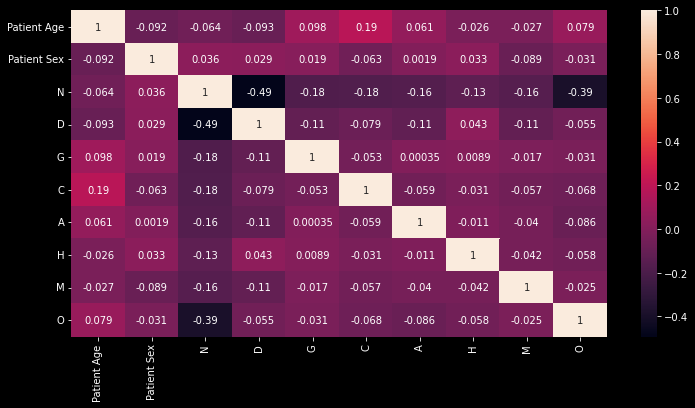

In [ ]:
plt.figure(figsize=(12, 6))
sns.heatmap( df_vis[['Patient Age' , 'Patient Sex', 'N' , 'D' , 'G' , 'C' , 'A' , 'H' , 'M' , 'O']].corr() , annot = True )


There`s no any notable correlation between any of these data 

##Diseases frequency in the data

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

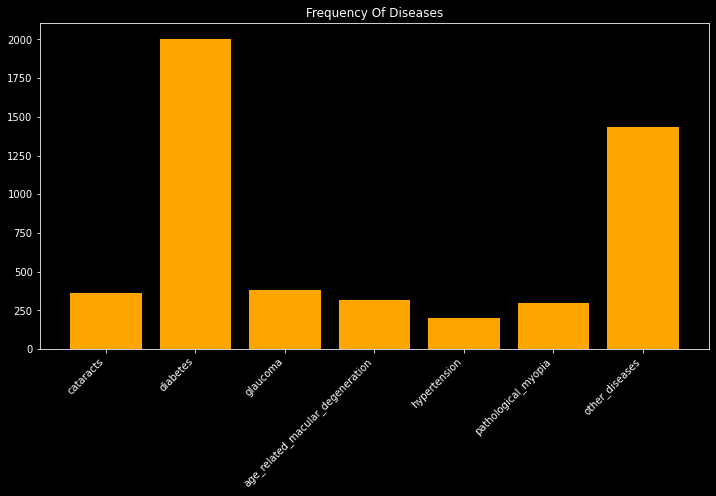

In [ ]:
plt.figure(figsize=(12,6))
plt.bar(range(len(diseases_dect_lengthes)), diseases_dect_lengthes.values(), tick_label=list(diseases_dect_lengthes.keys()) , color = 'orange'  )
plt.title("Frequency Of Diseases")
plt.xticks(rotation=45, ha='right')


(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

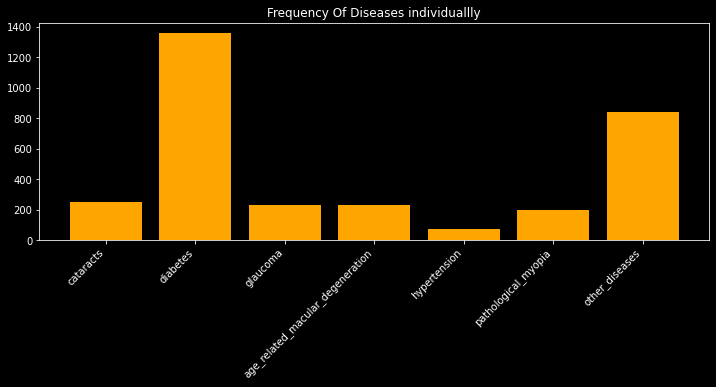

In [ ]:
plt.figure(figsize=(12,4))
plt.bar(range(len(individual_diseases_dect_lengthes)), individual_diseases_dect_lengthes.values(), tick_label=list(individual_diseases_dect_lengthes.keys()) , color = 'orange' )
plt.title("Frequency Of Diseases individuallly")
plt.xticks(rotation=45, ha='right')


Text(0.5, 0, 'Ages')

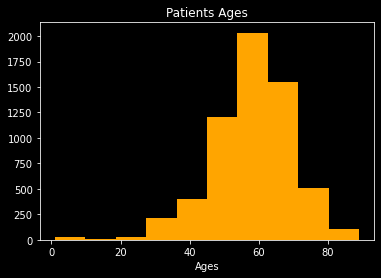

In [ ]:
plt.hist(df['Patient Age'] , color = 'orange')
plt.title("Patients Ages")
plt.xlabel("Ages")

##Percentage of each diagnostic keyword for each disease

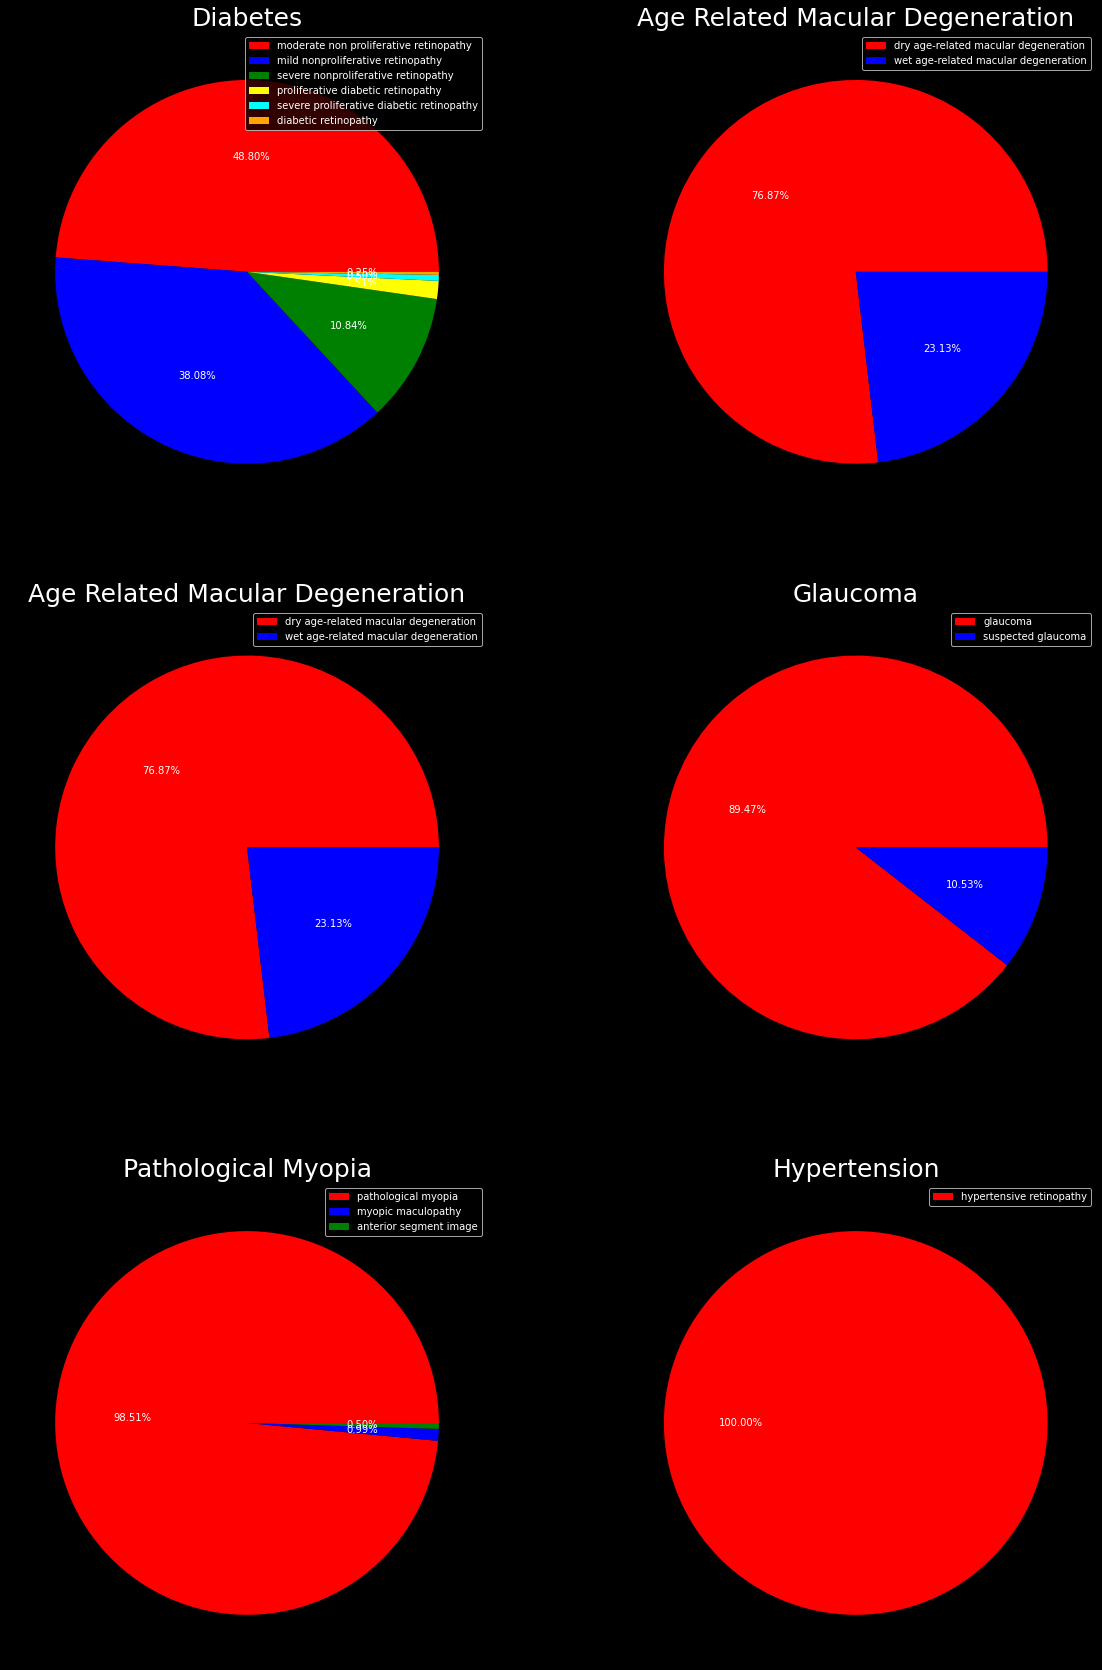

In [ ]:
colors = ['r' , 'b' , 'g' , 'yellow' , 'cyan' , 'orange']
plt.figure(figsize=(20,30))
ax1 = plt.subplot2grid((3,2),(0,1))
plt.title('Age Related Macular Degeneration',fontsize=25)
plt.pie(age_related_macular_degeneration_keywords , autopct='%1.2f%%' , colors= colors)
plt.legend(age_related_macular_degeneration_keywords.keys())

ax1 = plt.subplot2grid((3,2),(0,0))
plt.title('Diabetes',fontsize=25)
plt.pie(diabetes_keywords , autopct='%1.2f%%' , colors= colors)
plt.legend(diabetes_keywords.keys())

ax1 = plt.subplot2grid((3,2),(1,0))
plt.title('Age Related Macular Degeneration',fontsize=25)
plt.pie(age_related_macular_degeneration_keywords , autopct='%1.2f%%' , colors= colors)
plt.legend(age_related_macular_degeneration_keywords.keys())

ax1 = plt.subplot2grid((3,2),(1,1))
plt.title('Glaucoma',fontsize=25)
plt.pie(glaucoma_keywords , autopct='%1.2f%%' , colors= colors)
plt.legend(glaucoma_keywords.keys())

ax1 = plt.subplot2grid((3,2),(2,0))
plt.title('Pathological Myopia',fontsize=25)
plt.pie(pathological_myopia_keywords , autopct='%1.2f%%' , colors= colors)
plt.legend(pathological_myopia_keywords.keys())

ax1 = plt.subplot2grid((3,2),(2,1))
plt.title('Hypertension',fontsize=25)
plt.pie(hypertension_keywords , autopct='%1.2f%%' , colors= colors)
plt.legend(hypertension_keywords.keys())





##Visualizing each disease images compared to normal images

In [ ]:
from tqdm import tqdm
import os
import cv2
import random
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from skimage import exposure

In [ ]:
folder_dr = "/content/gdrive/MyDrive/Ocular_Disease_Recognition/preprocessed_images"


In [ ]:
def load_images_from_folder(folder , files_names):
    images = []
    for filename in files_names:
        img = plt.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

In [ ]:
# images_dict = {}
# for key, List in zip(only_lefts_dict.keys() , only_lefts_dict.values() ):
#   images_dict[key] = load_images_from_folder(folder_dr , List['Left-Fundus'])

In [ ]:
def plot_fundus(images_dict , keys=[] , image_effects_dict={}, randoms_seed =0 , num_of_columns = 5  ):
  #default case
  if len(keys) == 0:
    keys = images_dict.keys()
  
  plt.figure(figsize=(20*int(num_of_columns/5),20*len(keys)))# width , height

  for effect in image_effects_dict.keys():
    print(effect + '→' , end="")


  for j,key in  zip(range(len(images_dict)) ,keys) :
    for i in range(num_of_columns):
      image = images_dict[key][i+random_seed1*j]
      
      plt.subplot(2*len(keys) +2,num_of_columns,i+1+(num_of_columns*j))

      for effect in image_effects_dict.keys() :
        if effect == 'gamma' :
          image = exposure.adjust_gamma(image , gamma= image_effects_dict['gamma'])
        elif effect =='crop' :
          startX = image_effects_dict['crop'][0]
          startY = image_effects_dict['crop'][1]
          endX   = image_effects_dict['crop'][2]
          endY   = image_effects_dict['crop'][3]

          image = image[startY : endY , startX : endX]
        elif effect == 'resize' :
          image = cv2.resize(image , (image_effects_dict['resize'] , image_effects_dict['resize']))
        elif effect == 'threshold' :
          start = image_effects_dict['threshold'][0]
          end   = image_effects_dict['threshold'][1]
          ret , thresh = cv2.threshold(image , start, end, cv2.THRESH_TOZERO  )
          image = thresh
        elif effect == 'gray' or effect =='grey' :
          image = color.rgb2gray(image)
        elif effect == 'channel' :
          image = image[: , : , image_effects_dict['channel']]
        elif effect == 'mark_brightest' :
          # plt.imshow(image)
          v1 , v2, minLoc , maxLoc = cv2.minMaxLoc(image)
          plt.plot(maxLoc[0] ,maxLoc[1], "xr", markersize=25)
        elif effect == 'gaussian' :
          radius = image_effects_dict['gaussian']
          # image = color.rgb2gray(image)
          image = skimage.filters.gaussian(image ,sigma= (radius , radius))
          
        elif effect == 'canny' :
          if(image.shape[2] == 3) :#if RGB turn into gray
            image = color.rgb2grey(image)
          image = canny(image)
      
          
       
      plt.imshow(image)
      plt.xlabel(only_lefts_dict[key]['Left-Diagnostic Keywords'].values[i] + '\n(' +key+')' + f"\ngamma = {image_effects_dict['gamma']}"   , fontsize=16)

  plt.tight_layout()  



gamma→

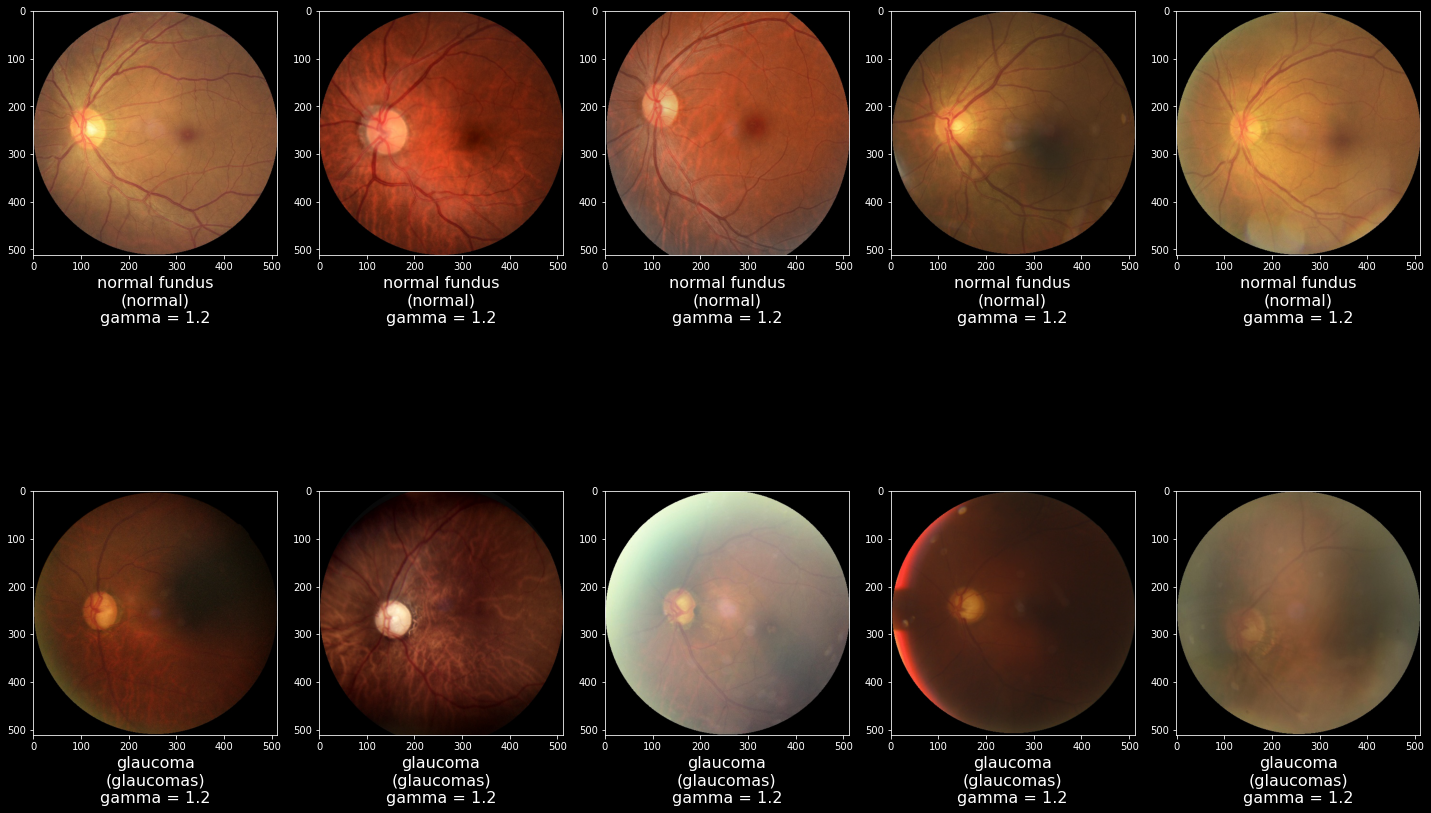

In [ ]:
import skimage
random_seed1 = 3
keys = images_dict.keys() 
image_effects_dict = {
                        'gamma'     : 1.2
}
plot_fundus(images_dict , ['normal' , 'glaucomas'  ] , image_effects_dict=image_effects_dict , randoms_seed=random_seed1 )


In [ ]:
# import skimage
# random_seed1 = 3
# keys = images_dict.keys() 
# image_effects_dict = {
#                         'threshold' : [50 , 255],
#                         'gamma'     : 2 , 
#                         'resize'    : 16 ,
#                         'channel'   : 0,
#                         'mark_brightest' : '',
#                         # 'gaussian'  : 50
# }
# plot_fundus(images_dict , ['normal' , 'glaucomas'  ] , image_effects_dict=image_effects_dict , randoms_seed=random_seed1 )


In [ ]:
# import skimage
# random_seed1 = 3
# keys = images_dict.keys() 
# image_effects_dict = {
#                         'threshold' : [50 , 255],
#                         'gamma'     : 2 , 
#                         'resize'    : 16
                      
#                         # 'gaussian'  : 50
# }
# plot_fundus(images_dict , ['normal' , 'glaucomas'  ] , image_effects_dict=image_effects_dict , randoms_seed=random_seed1 )


In [ ]:
# im = images_dict['normal'][5][:,:,0]
# # im = cv2.boxFilter(im , -1 , (50,50) )
# im = cv2.resize(im,(8,8))
# plt.imshow(im )

#Model

In [ ]:
cataract  = np.concatenate(   ( df[ df['LC'] == 1 ]['Left-Fundus'].values , df[ df['RC'] == 1 ]['Right-Fundus'].values ),axis=0)
normal    = np.concatenate(   ( df[ df['LN'] == 1 ]['Left-Fundus'].values , df[ df['RN'] == 1 ]['Right-Fundus'].values ),axis=0)



In [ ]:
cataract[0]

'0_left.jpg'

In [ ]:
(cataract.shape , normal.shape)

((540,), (5412,))

In [ ]:
dataset_dir = "/content/gdrive/MyDrive/Ocular_Disease_Recognition/preprocessed_images"


##Defining helping functions

A function to create dataset of only diseased and normal images with there labels 0,1 with ability to add effects on images easily

In [ ]:
def create_dataset(disease_data , normal_data , dataset_dir ,image_effects_dict={} , image_size = (512,512) , sample_size = -1  , random_state=42) :
  #print the sequence of effects 
  for key in image_effects_dict.keys() :
    print(key + '→', end="" )
  print("/n")
  #balancing data
  if sample_size != -1 :#default state
    disease_data = np.random.choice(disease_data , sample_size , replace=False)
    normal_data  = np.random.choice(normal_data , sample_size , replace=False)
  else:
    normal_data =  np.random.choice(normal_data , len(disease_data) , replace=False )

  dataset = []

  if not 'crop' in image_effects_dict.keys() :
    image_size = (224 , 224)

  for label , data in zip( [1,0] , [disease_data , normal_data]) :
    #appending  data
    for img in tqdm(data) :
      image_path = os.path.join(dataset_dir , img)
      image = plt.imread(image_path)
      image = cv2.resize(image , image_size )
      #applying image effects
      for effect in image_effects_dict.keys() :
        if effect == 'gamma' :
          image = exposure.adjust_gamma(image , gamma= image_effects_dict['gamma'])
        elif effect =='crop' :
          startX = image_effects_dict['crop'][0]
          endX   = image_effects_dict['crop'][1]
          startY = image_effects_dict['crop'][2]
          endY   = image_effects_dict['crop'][3]

          image = image[startY : endY , startX : endX]
        elif effect == 'threshold' :
          start = image_effects_dict['threshold'][0]
          end   = image_effects_dict['threshold'][1]
          ret , thresh = cv2.threshold(image , start, end, cv2.THRESH_TOZERO  )
          image = thresh
        elif effect == 'gray' or effect =='grey' :
          image = color.rgb2gray(image)
        elif effect == 'mirror' :
          image = cv2.flip(image , 1)
        elif effect == 'canny' :
          if(image.shape[2] == 3) :#if RGB turn into gray
            image = color.rgb2gray(image)
          image = canny(image)

      dataset.append([np.array(image) , np.array(label)])
    random.shuffle(dataset)
  
  return dataset


A function to plot a random sample from dataset

In [ ]:
def plot_from_dataset(dataset , disease_name):
  plt.figure(figsize=(12,7))
  for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    if category== 0:
        label = "Normal"
    else:
        label = disease_name
    plt.subplot(2,5,i+1)
    if len(image.shape) == 2 : #gray sacale
      plt.imshow(image , cmap = 'gray')
    elif image.shape[2] == 1 :
      plt.imshow(image , cmap = 'gray')
    else :
      plt.imshow(image)
    plt.xlabel(label)
  plt.tight_layout()  

A fucntion to plot losses and accuracies for model evaluation

In [ ]:
def plot_losses(losses) :
  plt.figure(figsize=(12,6))
  # plt.subplot(1,2,1)
  losses[['loss' , 'val_loss']].plot()
  # plt.subplot(1,2,2)
  losses[['accuracy' , 'val_accuracy']].plot()


##Cataract detection

###VGG16 Model

####helping functions

In [ ]:
# def get_optic_disk(dataset) :


####Preparing data 

In [ ]:
dataset_VGG16_cataract_effects_dict = {
                        'gamma'     : .9
}

VGG16_cataract_dataset = create_dataset(cataract, normal ,dataset_dir , dataset_VGG16_cataract_effects_dict)

gamma→/n


100%|██████████| 540/540 [02:22<00:00,  3.78it/s]


In [ ]:
np.shape(VGG16_cataract_dataset)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


(1080, 2)

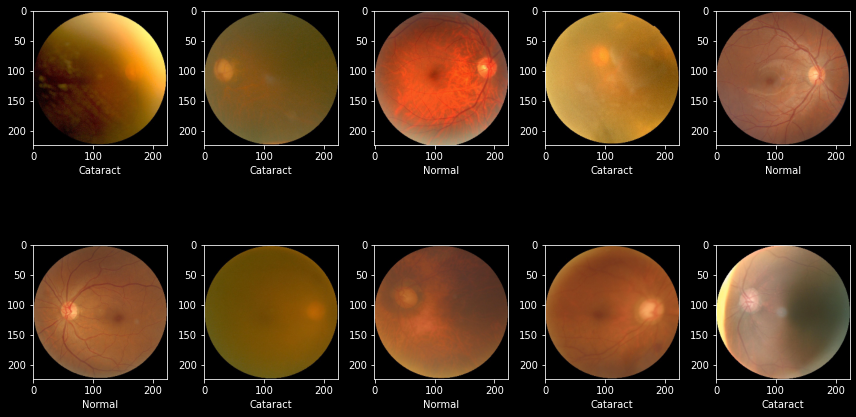

In [ ]:
plot_from_dataset(VGG16_cataract_dataset , 'Cataract')

In [ ]:
x_VGG16_cataract = np.array([i[0] for i in VGG16_cataract_dataset])
y_VGG16_cataract = np.array([i[1] for i in VGG16_cataract_dataset])

In [ ]:
(x_VGG16_cataract.shape, y_VGG16_cataract.shape )

((1080, 224, 224, 3), (1080,))

In [ ]:
from sklearn.model_selection import train_test_split
x_train_VGG16_cataract , x_test_VGG16_cataract , y_train_VGG16_cataract, y_test_VGG16_cataract = train_test_split(x_VGG16_cataract,y_VGG16_cataract,test_size=0.2, random_state=0)

In [ ]:
(x_train_VGG16_cataract.shape , x_test_VGG16_cataract.shape , y_train_VGG16_cataract.shape , y_test_VGG16_cataract.shape)

((864, 224, 224, 3), (216, 224, 224, 3), (864,), (216,))

In [ ]:
from tensorflow.keras.utils import to_categorical
y_train_VGG16_cataract_categorical = to_categorical(y_train_VGG16_cataract, 1000)
y_test_VGG16_cataract_categorical = to_categorical(y_test_VGG16_cataract,1000)
y_test_VGG16_cataract_categorical.shape

(216, 1000)

In [ ]:
(x_train_VGG16_cataract.shape , x_test_VGG16_cataract.shape , y_train_VGG16_cataract_categorical.shape , y_test_VGG16_cataract_categorical.shape)

((864, 224, 224, 3), (216, 224, 224, 3), (864, 1000), (216, 1000))

####Model Fitting

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

VGG16_cataract_model =VGG16(classifier_activation='softmax')

In [ ]:
from tensorflow.keras.optimizers import Adam
opt = Adam(lr=0.001)
VGG16_cataract_model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop=EarlyStopping(monitor='val_loss',patience=2)

In [ ]:
y_train_VGG16_cataract_categorical.shape

(864, 1000)

In [ ]:
VGG16_cataract_model.fit(x_train_VGG16_cataract
                         , y_train_VGG16_cataract_categorical
                         ,epochs=50
                         ,validation_data=(x_test_VGG16_cataract, y_test_VGG16_cataract_categorical)
                         ,callbacks=[early_stop])

Epoch 1/50
27/27 [==============================] - 29s 1s/step - loss: 56.0972 - accuracy: 0.5116 - val_loss: 0.7214 - val_accuracy: 0.5139
Epoch 2/50
27/27 [==============================] - 27s 1s/step - loss: 0.7578 - accuracy: 0.5370 - val_loss: 0.6920 - val_accuracy: 0.5093
Epoch 3/50
27/27 [==============================] - 27s 1s/step - loss: 0.7547 - accuracy: 0.5590 - val_loss: 0.6616 - val_accuracy: 0.5787
Epoch 4/50
27/27 [==============================] - 27s 1s/step - loss: 0.7170 - accuracy: 0.5903 - val_loss: 0.7366 - val_accuracy: 0.5509
Epoch 5/50
27/27 [==============================] - 27s 1s/step - loss: 0.6577 - accuracy: 0.6019 - val_loss: 0.6147 - val_accuracy: 0.6991
Epoch 6/50
27/27 [==============================] - 28s 1s/step - loss: 0.6178 - accuracy: 0.6725 - val_loss: 0.6768 - val_accuracy: 0.5880
Epoch 7/50
27/27 [==============================] - 27s 1s/step - loss: 0.6940 - accuracy: 0.6181 - val_loss: 0.5379 - val_accuracy: 0.7130
Epoch 8/50
27/27 [=

####Model Evaluation

In [ ]:
VGG16_losses=pd.DataFrame(VGG16_cataract_model.history.history)

In [ ]:
VGG16_losses.tail()

,loss,accuracy,val_loss,val_accuracy
11,0.338663,0.856481,0.358653,0.833333
12,0.296860,0.888889,0.434828,0.833333
13,0.273873,0.894676,0.301658,0.851852
14,0.234026,0.903935,0.311117,0.879630
15,0.219122,0.912037,0.389973,0.870370


<Figure size 864x432 with 0 Axes>

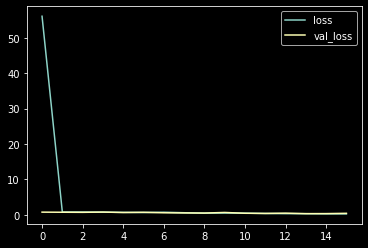

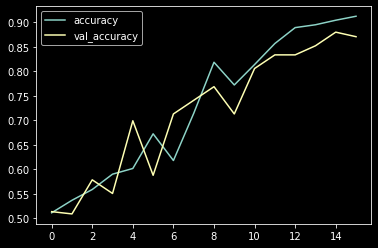

In [ ]:
plot_losses(VGG16_losses)

In [ ]:
def get_predictions(model , x_test) :
  start_time = time.time()
  predictions = np.argmax(model.predict(x_test) , axis=-1)
  end_time = time.time()
  return( (end_time-start_time)/len(x_test) , predictions )

In [ ]:
VGG16_time , VGG16_predictions = get_predictions(VGG16_cataract_model , x_test_VGG16_cataract)

In [ ]:
# VGG16_predictions=np.argmax(VGG16_model.predict(x_test),axis=-1)

In [ ]:
VGG16_confusion = confusion_matrix(VGG16_predictions, y_test_VGG16_cataract)

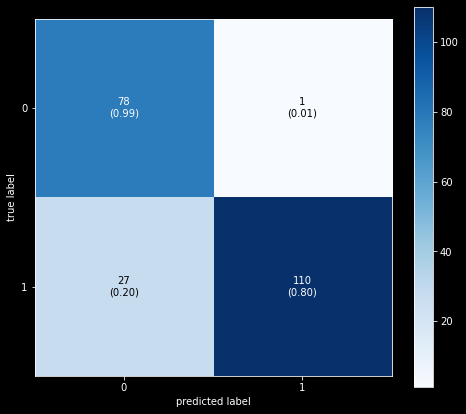

In [ ]:
from mlxtend.plotting import plot_confusion_matrix

plot_confusion_matrix(conf_mat = VGG16_confusion,figsize=(8,7),show_normed = True, colorbar= True);

In [ ]:
print(classification_report(y_test_VGG16_cataract, VGG16_predictions ) )

              precision    recall  f1-score   support

           0       0.99      0.74      0.85       105
           1       0.80      0.99      0.89       111

    accuracy                           0.87       216
   macro avg       0.90      0.87      0.87       216
weighted avg       0.89      0.87      0.87       216



###Customized Model 

####Preparing data 

In [ ]:
cataract_dataset_effects_dict = {
                        'gamma' : 1.2,
                        'canny' : 'canny'
}
cataract_dataset = create_dataset(cataract, normal ,dataset_dir , cataract_dataset_effects_dict)

gamma→canny→/n


100%|██████████| 540/540 [01:42<00:00,  5.26it/s]


In [ ]:
np.shape(cataract_dataset)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


(1080, 2)

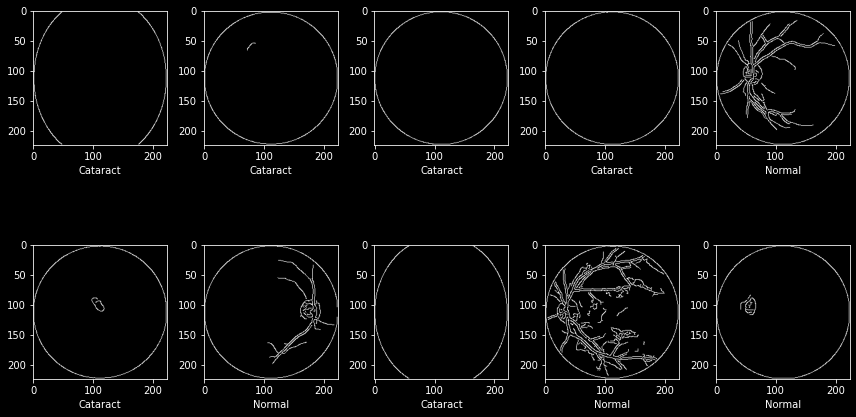

In [ ]:
plot_from_dataset(cataract_dataset , 'Cataract')

In [ ]:
x_cataract = np.array([i[0] for i in cataract_dataset])
y_cataract = np.array([i[1] for i in cataract_dataset])

In [ ]:
from sklearn.model_selection import train_test_split
x_train_cataract,x_test_cataract,y_train_cataract,y_test_cataract = train_test_split(x_cataract,y_cataract,test_size=0.2, random_state=0)

In [ ]:
from tensorflow.keras.utils import to_categorical
y_train_cataract_categorical = to_categorical(y_train_cataract, 10)
y_test_cataract_categorical = to_categorical(y_test_cataract,10)
y_test_cataract_categorical.shape

(216, 10)

In [ ]:
x_train_cataract.shape

(864, 224, 224)

####Model Fitting

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,BatchNormalization,Dropout,MaxPool2D

In [ ]:
model=Sequential()
input_shape = (224, 224, 1)

In [ ]:

model.add(Conv2D(filters=32,kernel_size=(3,3),input_shape=input_shape,activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=32,kernel_size=(3,3),input_shape=input_shape,activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(128,activation='relu'))

model.add(Dense(10,activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 93312)             0         
                                                                 
 dense_8 (Dense)             (None, 128)              

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop=EarlyStopping(monitor='val_loss',patience=2)

In [ ]:
model.fit(x_train_cataract, y_train_cataract_categorical,epochs=25,validation_data=(x_test_cataract, y_test_cataract_categorical),callbacks=[early_stop] )

Epoch 1/25
27/27 [==============================] - 3s 88ms/step - loss: 0.4701 - accuracy: 0.8356 - val_loss: 0.2193 - val_accuracy: 0.9259
Epoch 2/25
27/27 [==============================] - 2s 71ms/step - loss: 0.1766 - accuracy: 0.9271 - val_loss: 0.1402 - val_accuracy: 0.9491
Epoch 3/25
27/27 [==============================] - 2s 71ms/step - loss: 0.0990 - accuracy: 0.9630 - val_loss: 0.1502 - val_accuracy: 0.9398
Epoch 4/25
27/27 [==============================] - 2s 72ms/step - loss: 0.0689 - accuracy: 0.9815 - val_loss: 0.1067 - val_accuracy: 0.9630
Epoch 5/25
27/27 [==============================] - 2s 76ms/step - loss: 0.0660 - accuracy: 0.9792 - val_loss: 0.4417 - val_accuracy: 0.7917
Epoch 6/25
27/27 [==============================] - 2s 71ms/step - loss: 0.0888 - accuracy: 0.9699 - val_loss: 0.1426 - val_accuracy: 0.9352


####Model Evaluation

In [ ]:
losses=pd.DataFrame(model.history.history)

In [ ]:
losses.tail()

,loss,accuracy,val_loss,val_accuracy
1,0.176622,0.927083,0.140183,0.949074
2,0.099033,0.962963,0.150221,0.939815
3,0.068922,0.981481,0.106750,0.962963
4,0.065981,0.979167,0.441682,0.791667
5,0.088847,0.969907,0.142556,0.935185


<Figure size 864x432 with 0 Axes>

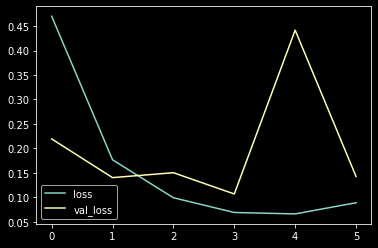

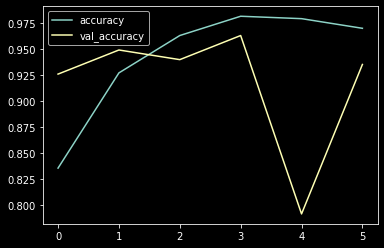

In [ ]:
plot_losses(losses)

In [ ]:
def get_predictions(model , x_test) :
  start_time = time.time()
  predictions = np.argmax(model.predict(x_test) , axis=-1)
  end_time = time.time()
  return( (end_time-start_time)/len(x_test) , predictions )
  

In [ ]:
cataract_time , cataract_predictions = get_predictions(model , x_test_cataract)

In [ ]:
cataract_confusion = confusion_matrix(cataract_predictions, y_test_cataract)

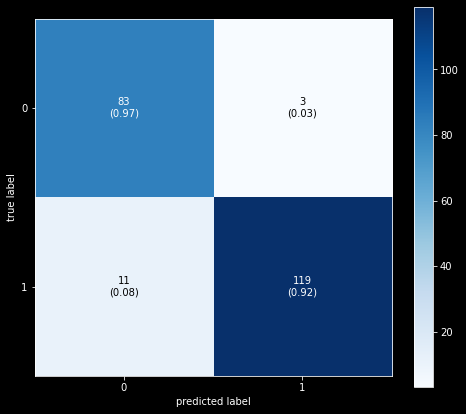

In [ ]:
from mlxtend.plotting import plot_confusion_matrix

plot_confusion_matrix(conf_mat = cataract_confusion,figsize=(8,7),show_normed = True, colorbar= True);

In [ ]:
VGG16_time / cataract_time

7.628740767794016

In [ ]:
print(classification_report(y_test_cataract, cataract_predictions ) )

              precision    recall  f1-score   support

           0       0.97      0.88      0.92        94
           1       0.92      0.98      0.94       122

    accuracy                           0.94       216
   macro avg       0.94      0.93      0.93       216
weighted avg       0.94      0.94      0.93       216



##Glaucoma Detection

###Preparing Data

In [ ]:


left_glaucoma = df[(df['LG'] == 1) & (df['LC'] == 0) ]['Left-Fundus'].values
right_glaucoma = df[(df['RG'] == 1) & (df['RC'] == 0) ]['Right-Fundus'].values

left_normal   = df[ df['LN'] == 1 ]['Left-Fundus'].values
right_normal  = df[ df['RN'] == 1 ]['Right-Fundus'].values



In [ ]:
len(left_glaucoma)

318

In [ ]:
left_glaucoma = left_glaucoma[left_glaucoma != '1412_left.jpg']

In [ ]:
dataset_left_glaucoma_effects_dict = {
                                        'crop'   : [0 , 224 , (256-112)+15 , (256+112)+15 ],
                                        'gamma'  : 2
                                        # 'threshold' : [50 , 255]
} 

dataset_right_glaucoma_effects_dict = {
                                        'mirror' : 'mirror',
                                        'crop'   : [0 , 224 , (256-112)+15 , (256+112)+15 ],
                                        'gamma'  : 2 
                                      #  'threshold' : [50,255]
              
}



left_glaucoma_dataset = create_dataset(left_glaucoma, left_normal ,dataset_dir , dataset_left_glaucoma_effects_dict)
right_glaucoma_dataset = create_dataset(right_glaucoma, right_normal ,dataset_dir , dataset_right_glaucoma_effects_dict)



crop→gamma→/n


100%|██████████| 317/317 [00:21<00:00, 14.42it/s]


mirror→crop→gamma→/n


100%|██████████| 274/274 [00:49<00:00,  5.54it/s]


In [ ]:
( np.shape(left_glaucoma_dataset) , np.shape(right_glaucoma_dataset))

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


((634, 2), (548, 2))

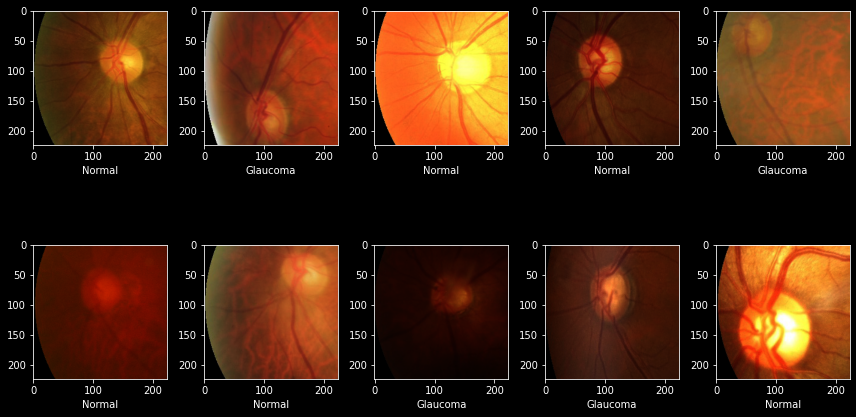

In [ ]:
plot_from_dataset(right_glaucoma_dataset , 'Glaucoma')

In [ ]:
glaucoma_dataset = left_glaucoma_dataset + right_glaucoma_dataset

In [ ]:
len(glaucoma_dataset)

1182

In [ ]:
type(left_glaucoma_dataset)

list

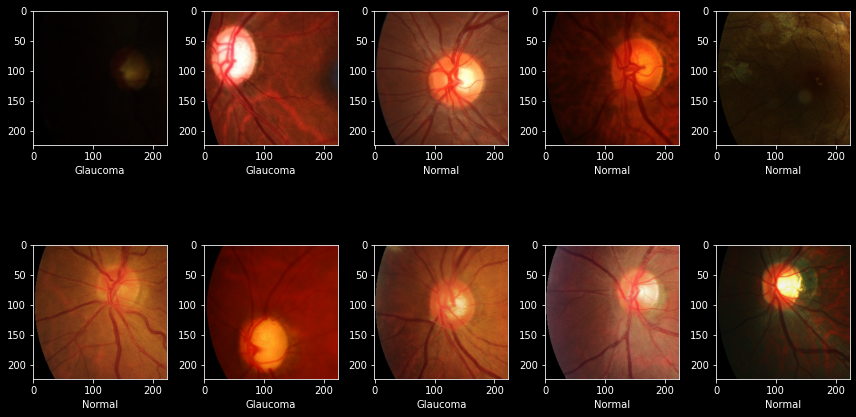

In [ ]:
plot_from_dataset(glaucoma_dataset , 'Glaucoma')

In [ ]:
x_glaucoma = np.array([i[0] for i in glaucoma_dataset])
y_glaucoma = np.array([i[1] for i in glaucoma_dataset])

In [ ]:
from sklearn.model_selection import train_test_split
x_train_glaucoma , x_test_glaucoma , y_train_glaucoma, y_test_glaucoma = train_test_split(x_glaucoma,y_glaucoma,test_size=0.2, random_state=0)

In [ ]:
(x_train_glaucoma.shape , x_test_glaucoma.shape , y_train_glaucoma.shape , y_test_glaucoma.shape)

((945, 224, 224, 3), (237, 224, 224, 3), (945,), (237,))

In [ ]:
from tensorflow.keras.utils import to_categorical
y_train_glaucoma_categorical = to_categorical(y_train_glaucoma, 1000)
y_test_glaucoma_categorical = to_categorical(y_test_glaucoma,1000)
y_test_glaucoma.shape

(237,)

In [ ]:
(x_train_glaucoma.shape , x_test_glaucoma.shape , y_train_glaucoma_categorical.shape , y_test_glaucoma_categorical.shape)

((945, 224, 224, 3), (237, 224, 224, 3), (945, 1000), (237, 1000))

####Model Fitting

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

glaucoma_model =VGG16(classifier_activation='softmax')

In [ ]:
from tensorflow.keras.optimizers import Adam
opt = Adam(lr=0.001)
glaucoma_model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop=EarlyStopping(monitor='val_loss',patience=2)

In [ ]:
y_train_glaucoma_categorical.shape

(945, 1000)

In [ ]:
glaucoma_model.fit(x_train_glaucoma
                         , y_train_glaucoma_categorical
                         ,epochs=50
                         ,validation_data=(x_test_glaucoma, y_test_glaucoma_categorical)
                         ,callbacks=[early_stop]
                   )

Epoch 1/50
30/30 [==============================] - 64s 1s/step - loss: 20.5930 - accuracy: 0.5132 - val_loss: 1.0711 - val_accuracy: 0.4346
Epoch 2/50
30/30 [==============================] - 37s 1s/step - loss: 1.0283 - accuracy: 0.5534 - val_loss: 0.7117 - val_accuracy: 0.5063
Epoch 3/50
30/30 [==============================] - 37s 1s/step - loss: 0.6785 - accuracy: 0.5788 - val_loss: 0.7178 - val_accuracy: 0.5021
Epoch 4/50
30/30 [==============================] - 37s 1s/step - loss: 0.6724 - accuracy: 0.6032 - val_loss: 0.6615 - val_accuracy: 0.6287
Epoch 5/50
30/30 [==============================] - 37s 1s/step - loss: 0.6551 - accuracy: 0.6190 - val_loss: 0.7736 - val_accuracy: 0.4810
Epoch 6/50
30/30 [==============================] - 37s 1s/step - loss: 0.6607 - accuracy: 0.6021 - val_loss: 0.6570 - val_accuracy: 0.6245
Epoch 7/50
30/30 [==============================] - 37s 1s/step - loss: 0.6585 - accuracy: 0.6021 - val_loss: 0.6669 - val_accuracy: 0.6540
Epoch 8/50
30/30 [=

####Model Evaluation

In [ ]:
glaucoma_losses=pd.DataFrame(glaucoma_model.history.history)

In [ ]:
losses.tail()

,loss,accuracy,val_loss,val_accuracy
1,0.176622,0.927083,0.140183,0.949074
2,0.099033,0.962963,0.150221,0.939815
3,0.068922,0.981481,0.106750,0.962963
4,0.065981,0.979167,0.441682,0.791667
5,0.088847,0.969907,0.142556,0.935185


<Figure size 864x432 with 0 Axes>

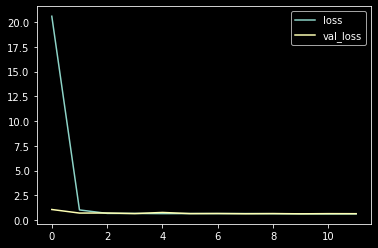

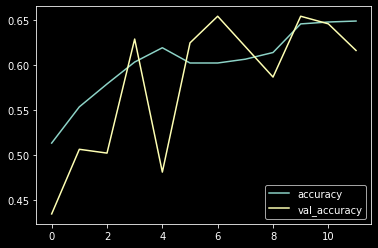

In [ ]:
plot_losses(glaucoma_losses)

In [ ]:
def get_predictions(model , x_test) :
  start_time = time.time()
  predictions = np.argmax(model.predict(x_test) , axis=-1)
  end_time = time.time()
  return( (end_time-start_time)/len(x_test) , predictions )
  

In [ ]:
glaucoma_time , glaucoma_predictions = get_predictions(glaucoma_model , x_test_glaucoma)

In [ ]:
glaucoma_confusion = confusion_matrix(glaucoma_predictions, y_test_glaucoma)

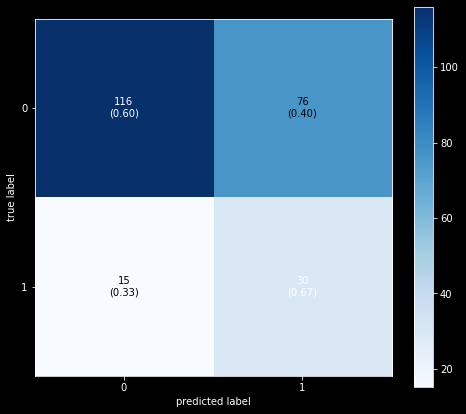

In [ ]:
from mlxtend.plotting import plot_confusion_matrix

plot_confusion_matrix(conf_mat = glaucoma_confusion,figsize=(8,7),show_normed = True, colorbar= True);

In [ ]:
glaucoma_time

0.02245307371083191

In [ ]:
print(classification_report(y_test_glaucoma, glaucoma_predictions ) )

              precision    recall  f1-score   support

           0       0.60      0.89      0.72       131
           1       0.67      0.28      0.40       106

    accuracy                           0.62       237
   macro avg       0.64      0.58      0.56       237
weighted avg       0.63      0.62      0.57       237

